In [96]:
# TO DO:
# call from csv for specific pokemon + stats
# call from csv for specific moves
# Physical Special split
# Typing for Type modifier
# debug damage calculation!!!
# list all EVs combo that match lowest total EVs
# add 0 EVs
# Ensure total EVs don't exceed 508
# IV modifier??
# level modifier?

from itertools import product
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Typing import typing

# Input the path to the CSV file
csv_path = "C:/Users/geekv/Pokemon-Double-Up-Damage-Calculator/pokemon_stats.csv"

pokemon_stats = {}
# Open the CSV file
with open(csv_path, 'r') as csvfile:
    # Create a CSV reader object
    csv_reader = csv.reader(csvfile)

    # Skip the header row
    next(csv_reader)

    for row in csv_reader:
            # Extract relevant information from the rows
            pokemon_name = row[1]
            form = row[2] if row[2] else "default"  # Use "default" if form is empty
            type1 = row[3]
            type2 = row[4]
            base_hp = int(row[5])
            base_attack = int(row[6])
            base_defense = int(row[7])
            base_special_attack = int(row[8])
            base_special_defense = int(row[9])
            base_speed = int(row[10])
            legal = int(row[11])  # 0 for illegal and 1 for legal

            # Create a tuple of base stats
            base_stats = (base_hp, base_attack, base_defense, base_special_attack, base_special_defense, base_speed)

            # Map the Pokémon name and form to its base stats
            key = (pokemon_name, form)
            pokemon_stats[key] = base_stats

# Define a function to get base stats for a given Pokémon name and form
def get_base_stats(pokemon_name, form="default"):
    return pokemon_stats.get((pokemon_name, form), None)

# Define the Pokémon names and forms for attacker and defender
attacker_pokemon = "Calyrex"
attacker_form = "Ice Rider"
defender_pokemon = "Amoonguss"
defender_form = "default"

# Get the base stats for the attacker and defender
atk_base = get_base_stats(attacker_pokemon, attacker_form)
def_base = get_base_stats(defender_pokemon, defender_form)

# # Debug print statements
# # Print the base stats to verify
# print(f"Base stats for {attacker_pokemon} ({attacker_form}): {atk_base}")
# print(f"Base stats for {defender_pokemon} ({defender_form}): {def_base}")

# Define nature effects
natures = {
    'Adamant': (1.0, 1.1, 1.0, 0.9, 1.0, 1.0),
    'Bashful': (1.0, 1.0, 1.0, 1.0, 1.0, 1.0), #Neutral
    'Bold': (1.0, 0.9, 1.1, 1.0, 1.0, 1.0),
    'Brave': (1.0, 1.1, 1.0, 1.0, 1.0, 0.9),
    'Calm': (1.0, 0.9, 1.0, 1.0, 1.1, 1.0),
    'Careful': (1.0, 1.0, 1.0, 0.9, 1.1, 1.0),
    'Docile': (1.0, 1.0, 1.0, 1.0, 1.0, 1.0),  # Neutral
    'Gentle': (1.0, 1.0, 0.9, 1.0, 1.1, 1.0),
    'Hardy': (1.0, 1.0, 1.0, 1.0, 1.0, 1.0),  # Neutral
    'Hasty': (1.0, 1.0, 0.9, 1.0, 1.0, 1.1),
    'Impish': (1.0, 1.0, 1.1, 0.9, 1.0, 1.0),
    'Jolly': (1.0, 1.0, 1.0, 0.9, 1.0, 1.1),
    'Lax': (1.0, 1.0, 1.1, 1.0, 0.9, 1.0),
    'Lonely': (1.0, 1.1, 0.9, 1.0, 1.0, 1.0),
    'Mild': (1.0, 1.0, 0.9, 1.1, 1.0, 1.0),
    'Modest': (1.0, 0.9, 1.0, 1.1, 1.0, 1.0),
    'Naive': (1.0, 1.0, 1.0, 1.0, 0.9, 1.1),
    'Naughty': (1.0, 1.1, 1.0, 1.0, 0.9, 1.0),
    'Quiet': (1.0, 1.0, 1.0, 1.1, 1.0, 0.9),
    'Quirky': (1.0, 1.0, 1.0, 1.0, 1.0, 1.0),  # Neutral
    'Rash': (1.0, 1.0, 1.0, 1.1, 0.9, 1.0),
    'Relaxed': (1.0, 1.0, 1.1, 1.0, 1.0, 0.9),
    'Sassy': (1.0, 1.0, 1.0, 1.0, 1.1, 0.9),
    'Serious': (1.0, 1.0, 1.0, 1.0, 1.0, 1.0),  # Neutral
    'Timid': (1.0, 0.9, 1.0, 1.0, 1.0, 1.1)
}

stages = {'-6': 2/8,
          '-5': 2/7,
          '-4': 2/6,
          '-3': 2/5,
          '-2': 2/4,
          '-1': 2/3,
          '0': 2/2,
          '1': 3/2,
          '2': 4/2,
          '3': 5/2,
          '4': 6/2,
          '5': 7/2,
          '6': 8/2}

# def_pokemon_type = "normal"
# atk_type = "normal"

# Apply nature
def apply_nature(stats, nature):
    nature_modifiers = natures[nature]
    return tuple(math.floor(stat * nature_mod) for stat, nature_mod in zip(stats, nature_modifiers))

IV = 31
level = 50
atk_nature = 'Adamant'
def_nature = 'Bold'
base_power = 120
Spread = 'True'
Crit = 'False'
STAB = "True"
Type = 2.0
stage_modifer = stages['0']

# Calculate stats
def calculate_stats(base, EV, nature):
    stats = []
    for i in range(6):
        if i == 0:  # HP
            stat = math.floor(((2 * base[i] + IV + math.floor(EV[i] / 4)) * level) / 100) + level + 10
        else:
            stat = math.floor(((2 * base[i] + IV + math.floor(EV[i] / 4)) * level) / 100) + 5
        stats.append(stat)
    return apply_nature(stats, nature)

# atk_pokemon_stats = calculate_stats(atk_base, atk_EV, atk_nature)
# def_pokemon_stats = calculate_stats(def_base, def_EV, def_nature)

# print("Attacker Stats:", atk_pokemon_stats)
# print("Defender Stats:", def_pokemon_stats)

# Custom rounding method (round down at 0.5)
def custom_round(x):
    """Custom rounding method to round down at 0.5"""
    return int(x + 0.5) if x - int(x) >= 0.5 else int(x)

# Calculate damage
def damage_calc(level, base_power, atk_pokemon_stats, def_pokemon_stats):
    # Calculate the intermediate values, rounding each multiplication to the nearest integer
    damage = (((2 * level )/ 5 + 2) * base_power * ((calculate_stats(atk_base, atk_EV, atk_nature)[1]*stage_modifer) / calculate_stats(def_base, def_EV, def_nature)[2]) / 50 + 2)
    return damage

# Calculate spread modifier
def spread_modifer(level, base_power, atk_pokemon_stats, def_pokemon_stats):
    damage = math.floor(damage_calc(level, base_power, atk_pokemon_stats, def_pokemon_stats))
    if Spread == 'True':
        spread_modifer = 0.75
    else:
        spread_modifer = 1
    return damage * spread_modifer

# Calculate crit modifier
def crit_modifer(level, base_power, atk_pokemon_stats, def_pokemon_stats):
    damage = math.floor(spread_modifer(level, base_power, atk_pokemon_stats, def_pokemon_stats))
    if Crit == 'True':
        crit_modifer = 1.5
    else:
        crit_modifer = 1
    return damage * crit_modifer

# Iterate through all possible EV combinations for attacker

results = []
step = 8  # Change this to the step value you desire (e.g., 4, 8, 12, etc.)

# Iterate through all possible EV combinations for attacker
for hp_evs in range(4, 256, step):
    for def_evs in range(4, 256, step):
        atk_EV = (4, 252, 0, 0, 0, 252)
        def_EV = (hp_evs, 0, def_evs, 0, 0, 0)

        # Calculate stats for attacking Pokémon
        atk_pokemon_stats = calculate_stats(atk_base, atk_EV, atk_nature)

        # Calculate stats for defending Pokémon
        def_pokemon_stats = calculate_stats(def_base, def_EV, def_nature)

        damage_rolls = []
        for i in range(85, 101):  # Multiply by 0.85 to 1, inclusive
            multiplier = i / 100  # Convert the range to a float multiplier
            damage = math.floor(crit_modifer(level, base_power, atk_pokemon_stats[1], def_pokemon_stats[2]) * multiplier)
            damage_rolls.append(damage)

        # Apply STAB modifier rounding
        if STAB == 'True':
            STAB_modifier = 1.5
        else:
            STAB_modifier = 1
        damage_rolls = [math.floor(damage * STAB_modifier) for damage in damage_rolls]

        # Apply Type modifier rounding
        damage_rolls = [math.floor(damage * Type) for damage in damage_rolls]

        #Find min and max damage rolls
        Min_roll = min(damage_rolls)
        Max_roll = max(damage_rolls)

        # print(atk_EV[1], str(atk_nature), "Urshifu (Single Strike) Wicked Blow vs.",def_EV[0],"HP /",def_EV[2], "Def", str(def_nature), "Flutter Mane on a critical hit:",damage_rolls[0],"-",damage_rolls[-1], "(",round(Min_roll/calculate_stats(def_base, def_EV, def_nature)[0] * 100, 1),"% -",round(Max_roll/calculate_stats(def_base, def_EV, def_nature)[0] * 100, 1),"%)")
        # print(damage_rolls)
        # print("Total EVs:", (hp_evs + def_evs))
        
        result = {"HP EVs": hp_evs, "Def EVs": def_evs,"Total EVs": (hp_evs + def_evs), "Damage Rolls": damage_rolls, "Max Roll": round(Max_roll/calculate_stats(def_base, def_EV, def_nature)[0] * 100, 1)}
        results.append(result)
        # print(results)

def threshold(result):
    if result["Max Roll"] < 100:
        return result
    else:
        return None

filtered_results = list(filter(threshold, results))

# Find the result with the lowest "Total_EVs"
lowest_total_evs_result = min(filtered_results, key=lambda x: x["Total EVs"])

# Extract the minimum "Total_EVs" value
min_total_evs = lowest_total_evs_result["Total EVs"]

# Filter all results that have the same "Total_EVs" value
matching_results = [result for result in filtered_results if result["Total EVs"] == min_total_evs]

# Print the matching results
for result in matching_results:
    print(result)


Base stats for Calyrex (Ice Rider): (100, 165, 150, 85, 130, 50)
Base stats for Amoonguss (default): (114, 85, 70, 85, 80, 30)
{'HP EVs': 188, 'Def EVs': 252, 'Total EVs': 440, 'Damage Rolls': [180, 182, 182, 186, 188, 188, 192, 194, 198, 198, 200, 204, 204, 206, 210, 212], 'Max Roll': 99.5}


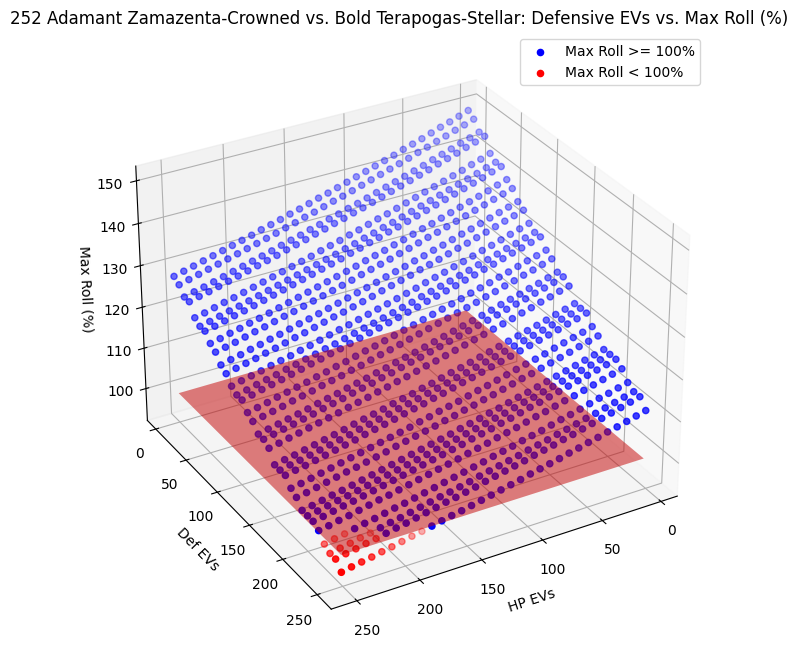

In [97]:
# 3D Plot inillustrating defensive EVs vs. damage rolls
# Extract data
hp_evs = [result["HP EVs"] for result in results]
def_evs = [result["Def EVs"] for result in results]
max_rolls = [result["Max Roll"] for result in results]

# Separate the points based on the condition Max Roll < 100
highlight_hp_evs = [hp_evs[i] for i in range(len(max_rolls)) if max_rolls[i] < 100]
highlight_def_evs = [def_evs[i] for i in range(len(max_rolls)) if max_rolls[i] < 100]
highlight_max_rolls = [max_rolls[i] for i in range(len(max_rolls)) if max_rolls[i] < 100]

normal_hp_evs = [hp_evs[i] for i in range(len(max_rolls)) if max_rolls[i] >= 100]
normal_def_evs = [def_evs[i] for i in range(len(max_rolls)) if max_rolls[i] >= 100]
normal_max_rolls = [max_rolls[i] for i in range(len(max_rolls)) if max_rolls[i] >= 100]

# Create the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot normal points

ax.scatter(normal_hp_evs, normal_def_evs, normal_max_rolls, c='b', marker='o', label='Max Roll >= 100%')

# Plot highlighted points
ax.scatter(highlight_hp_evs, highlight_def_evs, highlight_max_rolls, c='r', marker='o', label='Max Roll < 100%')

# Set labels
ax.set_xlabel('HP EVs')
ax.set_ylabel('Def EVs')
ax.set_zlabel('Max Roll (%)')

# Set the viewing angle (elevation, azimuth)
ax.view_init(elev=30, azim=60)

# Create a grid for the plane
x = np.linspace(min(hp_evs), max(hp_evs), 100)
y = np.linspace(min(def_evs), max(def_evs), 100)
x, y = np.meshgrid(x, y)
z = np.full_like(x, 100)  # Adjust the Z value for the plane as needed

# Plot the plane
ax.plot_surface(x, y, z, alpha=0.5, rstride=100, cstride=100, color='red')

# Set the title
title = f"{atk_EV[1]} {atk_nature} Zamazenta-Crowned vs. {def_nature} Terapogas-Stellar: Defensive EVs vs. Max Roll (%)"
ax.set_title(title)

# Add legend
ax.legend()

# Show plot
plt.show()